In [1]:
import ta
import trendet
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import sys
sys.path.append('/Users/jp/Desktop/Investment/utils')
import utils as utils
import math
from string import ascii_uppercase
from itertools import product
import os
from binance.client import Client
from binance.exceptions import *
import requests as requests
import time as time

In [2]:
class Macd_long_backtester_1stpkbm():
    
    '''
    Macd class for backtesting strategies
    How to use this class:
    1) Use 'prepare_data' method:
        INPUTS
        - start
        - end
        - interval
        - macd parameters
        
        COLUMNS CREATED
        - macd_diff
        - macd_macd
        - macd_signal
        - log_returns_hold
        - multiple_hold_acum
        - position
        - inv_sign
        
    In order to perform the backtest first it is necessary to follow 2.1) and 2.2) points in order to get the
    period of data of interest. Once this period (start and finish) has been chosen, it is necessary to create
    a new instance of the class and follow points 1) and 3)
        
    2.1) Use 'assign_trends' method: 
        INPUTS
        - window_size
        
        COLUMNS CREATED
        - Up Trend
        - Down Trend
    
    2.2) Use 'get_trend_dates' to obtain the dates 'start' and 'finish' for creating the new instance to perform
    the optimization
    
    3) Use 'execute_backtest' to perform the backtesting analysis for the period obtained, and with the macd
    paramters given in the point 1) in the new class instance
    
    SUMMARY:
    
    FIRST: points 1) 2.1) and 2.2) --> trends analysis and get period for analysis
    SECOND: points 1) and 3) --> new class instance for backtesting with period obtained with get_trend_dates 
    '''
    
    def __init__(self,symbol=None):
        
        """Macd long backtester constructor
        :param symbol: symbol from Binance from which to extract the data, .i.e. 'BTCUSDT'
        :type symbol: str.
        :param data: a dataframe with all the data extract from the Binance API for the selected function inputs.
        :type data: DataFrame
        :param data_uptrend: a dataframe with data extracted from self.data but only for the type of trend
        :type data_uptrend: str.
        :param data_downtrend: a dataframe with data extracted from self.data but only for the type of trend
        :type data_down_trend: str.
        :param data_sideways: a dataframe with data extracted from self.data but only for the type of trend
        :type data_sideways: str.
        """
        self.symbol = symbol
        self.data_init = pd.DataFrame()
        self.trend_assigned = None
        self.interval = None
        self.type_trend = None
        self.trend_ref = None
        #Read-only paramters below, only informative of the last data prepared
        self.start = None
        self.end = None
        self.ema_slow = None
        self.ema_fast = None
        self.ema_signal = None
        self.opt_results = None
        self.from_time = None
        self.to_time = None
    
    def __repr__(self):
        return f"Macd_long_backtester(symbol={self.symbol})"

    def prepare_data(self, start=None, end=None, interval=None):
        '''
        REMARK: Introduced time must be in Tokyo time (UTC+9) but the calculations will be in UTC
        Prepare all the fields of data necessary for the study. The interval of dates to be studied is the one
        given when delclaring the class. To prepare another interval of dates, please create another class instance.
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        :param interval: string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        '''

        self.start = start
        self.end = end
        self.interval = interval
        from_time = int(datetime.strptime(start, "%Y-%m-%d-%H:%M").timestamp()*1000)
        to_time = int(datetime.strptime(end, "%Y-%m-%d-%H:%M").timestamp()*1000)
        self.from_time = from_time
        self.to_time = to_time
        self.data_init = utils.get_history_v2(symbol=self.symbol, interval=interval, start=from_time, end=to_time)[0]
        self.data_init['log_returns_hold'] = np.log(self.data_init.Close.div(self.data_init.Close.shift(1)))
        self.data_init['multiple_hold_acum'] = np.exp(self.data_init.log_returns_hold.cumsum())
        #initialize positions and sign_inv
        self.data_init['position'] = 0
        self.data_init['inv_sign'] = 0
    
    def assign_trends(self, window_size=12, plot=False):
        '''
        REQUIREMENT: execute after "prepare_data" method AND a minimum window size of 12 days
        :param window_size: a trend that has a window higher than the introduced number is assigned.
        :type window_size: int.
        '''
        if (window_size < 12):
            print('Minimum window size is 12 (calculated with BTCUSDT so far)')
            return
        
        #THE SAMPLING INTERVAL MUST BE DAILY IN ORDER FOR THE ALGORITH TO WORK (AS FAR AS I KNOW)
        if (self.interval != '1d'):
            print("The interval that has to be used to assign trends is '1d'")
            return
        
        if (self.trend_assigned == True): 
            print("The trends have already been assigned, please execute first 'clean_assign_trend' before executing\
            this method again")
            return
        
        sns.set(style='darkgrid')
        res = trendet.identify_df_trends(df=self.data_init, column='Close', window_size=window_size)
        max_close = res.Close.max()      
                
        plt.figure(figsize=(20, 10))
        ax = sns.lineplot(x=res.index, y=res['Close'])
        labels = res['Up Trend'].dropna().unique().tolist()

        for label in labels:
            sns.lineplot(x=res.loc[res['Up Trend'] == label].index, y=res.loc[res['Up Trend'] == label].Close, color='green')
            pol1 = ax.axvspan(res.loc[res['Up Trend'] == label].index[0], res.loc[res['Up Trend'] == label].index[-1], alpha=0.2, color='green')
            coord = pol1.get_xy()
            xcoord = -1 + coord[0][0] + (coord[2][0] - coord[1][0])/2
            ax.annotate(label, (xcoord, max_close*3/4))

        labels = res['Down Trend'].dropna().unique().tolist()

        for label in labels:
            sns.lineplot(x=res.loc[res['Down Trend'] == label].index, y=res.loc[res['Down Trend'] == label].Close, color='red')
            pol2 =ax.axvspan(res.loc[res['Down Trend'] == label].index[0], res.loc[res['Down Trend'] == label].index[-1], alpha=0.2, color='red')
            coord = pol2.get_xy()
            xcoord = -1 + coord[0][0] + (coord[2][0] - coord[1][0])/2
            ax.annotate(label, (xcoord, max_close*2/4))

        increase_letter = False
        side_labels = []
        i = 0     
        
        for index, data in res.iterrows():
            if (not isinstance(data['Up Trend'], str) and not isinstance(data['Down Trend'], str)):
                if (increase_letter == True):
                    i+=1
                res.loc[index, 'Up Trend'] = ascii_uppercase[i]*2
                res.loc[index, 'Down Trend'] = ascii_uppercase[i]*2
                side_labels.append(ascii_uppercase[i]*2)
                increase_letter = False

            if (isinstance(data['Up Trend'], str) or isinstance(data['Down Trend'], str)):
                pass
                increase_letter = True 

        for label in side_labels:
            sns.lineplot(x=res.loc[res['Up Trend'] == label].index, y=res.loc[res['Up Trend'] == label].Close, color='blue')
            pol3 =ax.axvspan(res.loc[res['Up Trend'] == label].index[0], res.loc[res['Up Trend'] == label].index[-1], alpha=0.2, color='grey')
            coord = pol3.get_xy()
            xcoord = -0.5 + coord[0][0] + (coord[2][0] - coord[1][0])/2
            ax.annotate(label, (xcoord, max_close*1/4))

        self.trend_assigned = True
    
    def get_trend_dates(self, type_trend=None, trend_ref=None, do_plot=False):
        
        '''
        REQUIREMENT: execute after "assign_trends" method
        Once the trends have been assigned in data_init, in this function the type of trend seen in the trends chart
        and its trend_ref ('A', 'B', 'AA'...), are given and, as output we receive the start and the end dates of the trend.
        :param type: valid fields are 'Up Trend', 'Down Trend' and 'Sideways'
        :type type: str.
        :param trend_ref: letter/s that have been assigned in the 'Up Trend' and 'Down Trend' columns in data_init
        :type type: str.
        :param plot: if True, plots the selected trend
        :param type: bool.
        
        :return a tuple with two integers representing the time in milliseconds since the epoch for the start and end period.
        '''
        
        if (type_trend == 'Up Trend'):
            date_init = self.data_init.loc[self.data_init['Up Trend'] == trend_ref].index[0]
            date_end = self.data_init.loc[self.data_init['Up Trend'] == trend_ref].index[-1]
            if (do_plot == True):
                mask1 = (self.data_init.index >= date_init) 
                mask2 = (self.data_init.index <= date_end) 
                self.data_init.Close[mask1 & mask2].plot(figsize=(15,10))

        if (type_trend == 'Down Trend'):
            date_init = self.data_init.loc[self.data_init['Down Trend'] == trend_ref].index[0]
            date_end = self.data_init.loc[self.data_init['Down Trend'] == trend_ref].index[-1]
            if (do_plot == True):
                mask1 = (self.data_init.index >= date_init) 
                mask2 = (self.data_init.index <= date_end) 
                self.data_init.Close[mask1 & mask2].plot(figsize=(15,10)) 
                
        if (type_trend == 'Sideways'):
            #the letters are in both columns so it does not matter which column it is accesed
            date_init = self.data_init.loc[self.data_init['Up Trend'] == trend_ref].index[0]
            date_end = self.data_init.loc[self.data_init['Up Trend'] == trend_ref].index[-1]
            if (do_plot == True):
                mask1 = (self.data_init.index >= date_init) 
                mask2 = (self.data_init.index <= date_end) 
                self.data_init.Close[mask1 & mask2].plot(figsize=(15,10))            
   
        date_init_int = int(date_init.timestamp()*1000)
        date_end_int = int(date_end.timestamp()*1000)
        self.trend_type = type_trend
        self.trend_ref = trend_ref
       
        print('date_init:', date_init, date_init_int)
        print('date_end:', date_end, date_end_int)    
                                
        return (date_init_int, date_end_int)

    
    def clean_assign_trend(self):
        '''Delete the columns 'Up Trend' and 'Down Trend' in data_init generated by the 'assign_trend_method'
        '''
        if (self.trend_assigned == None):
            print('trends must be assigned first')
            return
        
        self.data_init.drop(columns=['Up Trend', 'Down Trend'], inplace=True)
        self.trend_assigned = False
        
    def execute_backtest(self, start=None, ema_slow=None, ema_fast=None, ema_signal=None):
        '''
        REQUIREMENT: execute after "prepare_data" method
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        '''
        #Prepare pre-data to start with non NaN at the backtesting period
        from_time_obj = datetime.strptime(start, "%Y-%m-%d-%H:%M")
#       ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        ema_diff = ema_slow + ema_signal + 2
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min*(ema_diff))
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h*(ema_diff))
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day*(ema_diff))
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week*(ema_diff))
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=num_week_m * 4 * (ema_diff))
        pre_from_time_obj = from_time_obj - td
        pre_from_time = int((from_time_obj - td).timestamp()*1000)
        self.data_init_pre = utils.get_history_v2(symbol=self.symbol, interval=self.interval, start=pre_from_time, end=self.to_time)[0]
        #Assign the MACD parameters to the class to see which para,tershave been used last
        self.ema_slow = ema_slow
        self.ema_fast = ema_fast
        self.ema_signal = ema_signal 
        #obtaining MACD instance from python ta
        macd_diff = ta.trend.MACD(close=self.data_init_pre.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data_init_pre.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data_init_pre.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd_signal()
        #assigning the values of macd to ticker dataframe
        self.data_init_pre['macd_diff'] = macd_diff
        self.data_init_pre['macd_macd'] = macd_macd
        self.data_init_pre['macd_signal'] = macd_signal   
        self.data_init = self.data_init_pre.loc[from_time_obj:].copy()
        #Initialize again buy-and-hold parameters for new data
        self.data_init['log_returns_hold'] = np.log(self.data_init.Close.div(self.data_init.Close.shift(1)))
        self.data_init['multiple_hold_acum'] = np.exp(self.data_init.log_returns_hold.cumsum())
        #initialize again positions and sign_inv for new data
        self.data_init['position'] = 0
        self.data_init['peak'] = 0
        #stablish neutral conditions
        cond1 = self.data_init.macd_diff.shift(-1) > 0
        cond2 = self.data_init.macd_diff > 0
        cond3 = self.data_init.macd_diff.shift(+1) > 0
        cond4 = self.data_init.macd_diff > self.data_init.macd_diff.shift(-1)
        cond5 = self.data_init.macd_diff > self.data_init.macd_diff.shift(+1)
        cond_all_neutral = cond1&cond2&cond3&cond4&cond5
        #stablish neutral positions
        self.data_init.loc[cond_all_neutral, 'peak'] = -1
        #stablish buy conditions
        cond6 = self.data_init.macd_diff.shift(-1) < 0
        cond7 = self.data_init.macd_diff < 0
        cond8 = self.data_init.macd_diff.shift(+1) < 0
        cond9 = self.data_init.macd_diff < self.data_init.macd_diff.shift(-1)
        cond10 = self.data_init.macd_diff < self.data_init.macd_diff.shift(+1)
        cond_all_buy = cond6&cond7&cond8&cond9&cond10
        #stablish buy positions
        self.data_init.loc[cond_all_buy, 'peak'] = 1
        #create neutral and buy positions algorithm
        for index, data in self.data_init.iterrows():
            if (data.peak == 1):
                self.data_init.loc[index, 'position'] = 1
                self.data_init_sub_sell = self.data_init.loc[index + timedelta(minutes=1):]
                for index_sub_sell, data_sub_sell in self.data_init_sub_sell.iterrows():
                    if (data_sub_sell.peak == 0):
                        self.data_init.loc[index_sub_sell, 'position'] = 1
                    if (data_sub_sell.peak != 0):
                        break
            if (data.peak == 0):
                pass
            if (data.peak == -1):
                self.data_init.loc[index, 'position'] = 0
                self.data_init_sub_buy = self.data_init.loc[index + timedelta(minutes=1):]
                for index_sub_buy, data_sub_buy in self.data_init_sub_buy.iterrows():
                    if (data_sub_buy.peak == 0):
                        self.data_init.loc[index_sub_buy, 'position'] = 0
                    if (data_sub_buy.peak != 0):
                        break
        #stablish the trading costs and the number of trades done
        self.data_init['trades'] = 0
        trading_cost = np.log(1 - 0.00075) + np.log(1 - 0.0001)
        trade_exec_cond = self.data_init.position.diff().fillna(0).abs() != 0
        self.data_init.loc[trade_exec_cond, 'trades'] = 1
        #calculate strategy returns
        self.data_init['macd_log_returns'] = self.data_init.log_returns_hold * self.data_init.position.shift(1)
        self.data_init['macd_log_returns_net'] = self.data_init.macd_log_returns + self.data_init.trades * trading_cost
        self.data_init['macd_log_returns_acum'] = np.exp(self.data_init.macd_log_returns.cumsum())
        self.data_init['macd_log_returns_net_acum'] = np.exp(self.data_init.macd_log_returns_net.cumsum())

        #calculating the function outputs
        multiple_hold = np.exp(self.data_init.log_returns_hold.sum())
        ann_log_mean_hold = self.data_init.log_returns_hold.mean() * 365
        ann_log_std_hold = self.data_init.log_returns_hold.std() * np.sqrt(365)
        sharpe_ratio_hold = ann_log_mean_hold / ann_log_std_hold
        
        multiple_macd_strategy = np.exp(self.data_init.macd_log_returns.sum())
        ann_log_mean_macd = self.data_init.macd_log_returns.mean() * 365
        ann_log_std_macd = self.data_init.macd_log_returns.std() * np.sqrt(365)
        sharpe_ratio_macd = ann_log_mean_macd / ann_log_std_macd
        
        multiple_macd_strategy_net = np.exp(self.data_init.macd_log_returns_net.sum())
        ann_log_mean_macd_net = self.data_init.macd_log_returns_net.mean() * 365
        ann_log_std_macd_net = self.data_init.macd_log_returns_net.std() * np.sqrt(365)
        sharpe_ratio_macd_net = ann_log_mean_macd_net / ann_log_std_macd_net
        tuple_return = (multiple_hold, ann_log_mean_hold, ann_log_std_hold, sharpe_ratio_hold, multiple_macd_strategy, ann_log_mean_macd, ann_log_std_macd, sharpe_ratio_macd, multiple_macd_strategy_net, ann_log_mean_macd_net, ann_log_std_macd_net, sharpe_ratio_macd_net)

        df_return = pd.DataFrame(data=[list(tuple_return)], columns=['multiple_hold', 'ann_log_mean_hold', 'ann_log_std_hold', 'sharpe_ratio_hold', 'multiple_macd_strategy', 'ann_log_mean_macd', 'ann_log_std_macd', 'sharpe_ratio_macd', 'multiple_macd_strategy_net', 'ann_log_mean_macd_net', 'ann_log_std_macd_net', 'sharpe_ratio_macd_net'])
        print(df_return)
        return tuple_return
    
    def plot_backtest_results(self):
        
        pass
    
    def execute_opt(self, start_opt=None, end_opt=None, interval_opt=None, ema_slow_opt=None, ema_fast_opt=None, ema_sign_opt=None, int_for_max=None, type_trend=None, trend_ref=None):
        '''
        REMARK: Introduced time must be in Tokyo time (UTC+9) but the calculations will be in UTC
        '''
        interval_opt = interval_opt
        macd_slow_opt = range(*ema_slow_opt)
        macd_fast_opt = range(*ema_fast_opt)
        macd_signal_opt = range(*ema_sign_opt)
        combinations = list(product(interval_opt, macd_slow_opt, macd_fast_opt, macd_signal_opt))
        
        results = []
        for comb in combinations:
            try:
                self.prepare_data(start=start_opt, end=end_opt, interval=comb[0])
                tuple_results = (*self.execute_backtest(start=self.start, ema_slow=comb[1], ema_fast=comb[2], ema_signal=comb[3]), trend_ref, start_opt, end_opt)
                results.append(tuple_results)
                print(f"processed {len(results)} out of a total {len(combinations)}")
            except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
                    print('Something went wrong. Error occured at %s. Wait for 1 min.' % (datetime.now().astimezone(timezone.utc)))
                    time.sleep(60)
                    api_key = "Q3Zsx6rO7uy0YntyWjb9CTGxbQAfENBxbPAkeOtksXm2AcLcu1y7IOj1fgPFtutO"
                    api_secret = "LeiOCoJdBuCtfgrt1WfsBweeyC2ZwuogPuDrkXFTioEGoaZYOGkju1GRM3yVqp7v"
                    client = Client(api_key, api_secret)
            except KeyboardInterrupt as e2:
                    print("error type is 'KeyboardInterrupt'. The data calculated so far has been stored in self.opt_results")
                    break
        
        combinations_df = pd.DataFrame(data=combinations, columns=['interval_opt', 'macd_slow_opt', 'macd_fast_opt', 'macd_signal_opt'])
        many_results_df = pd.DataFrame(data=results, columns = ['multiple_hold', 'ann_log_mean_hold', 'ann_log_std_hold', 'sharpe_ratio_hold', 'multiple_macd_strategy', 'ann_log_mean_macd', 'ann_log_std_macd', 'sharpe_ratio_macd', 'multiple_macd_strategy_net', 'ann_log_mean_macd_net', 'ann_log_std_macd_net', 'sharpe_ratio_macd_net', 'trend_ref', 'start_opt', 'end_opt'])
        mg=pd.merge(combinations_df,many_results_df, how='inner', left_index=True, right_index=True)
        #Filtering only meaningfull combinations
        cond1 = mg.multiple_macd_strategy != 1 #not enough data to carry out a single crossover
        cond2 = mg.macd_slow_opt > mg.macd_fast_opt
        mg_filt = mg.loc[cond1&cond2].copy()
        self.opt_results = mg_filt.copy()
        self.opt_comb_num = len(combinations)
        
        #only show results for desired interval
        cond3 = mg_filt.interval_opt == int_for_max
        mg_desired_interval = mg_filt[cond3].copy()
        
        cond_max = mg_desired_interval.multiple_macd_strategy == mg_desired_interval.multiple_macd_strategy.max()
        multiple_macd_strategy_opt_max = mg_desired_interval[cond_max]
        
        cond_net_max = mg_desired_interval.multiple_macd_strategy_net == mg_desired_interval.multiple_macd_strategy_net.max()
        multiple_macd_strategy_net_opt_max = mg_desired_interval[cond_net_max]
        
        self.multiple_macd_strategy_max = multiple_macd_strategy_opt_max
        self.multiple_macd_strategy_net_max = multiple_macd_strategy_net_opt_max

        if os.path.exists(f"{type_trend}.csv"):
            df_imported = pd.read_csv(f"{type_trend}.csv")
            df_complete = pd.concat([df_imported, self.opt_results], axis = 0)
            df_complete.to_csv(f"{type_trend}.csv", mode='w', index=False, header=True)
        else:
            self.opt_results.to_csv(f"{type_trend}.csv", mode='w', index=False, header=True)
        
        

In [3]:
test = Macd_long_backtester_1stpkbm('BTCUSDT')

In [ ]:
test1 = 

In [4]:
test.prepare_data(start='2018-01-07-00:00', end='2018-02-05-00:00', interval='1h')

697


In [5]:
test.execute_backtest(start='2018-01-07-00:00', ema_slow=20, ema_fast=10, ema_signal=20)

739
   multiple_hold  ann_log_mean_hold  ann_log_std_hold  sharpe_ratio_hold  \
0       0.495027          -0.373577          0.385361          -0.969419   

   multiple_macd_strategy  ann_log_mean_macd  ann_log_std_macd  \
0                0.920457          -0.044036           0.27086   

   sharpe_ratio_macd  multiple_macd_strategy_net  ann_log_mean_macd_net  \
0           -0.16258                    0.896512              -0.058041   

   ann_log_std_macd_net  sharpe_ratio_macd_net  
0              0.270957              -0.214206  


(0.4950270708191909,
 -0.3735766124098908,
 0.38536121710917515,
 -0.9694193287334733,
 0.920457168404467,
 -0.044036325644259,
 0.27085996134336504,
 -0.16257967927727354,
 0.8965119214041676,
 -0.058040678649483986,
 0.27095666683467756,
 -0.21420649776776715)

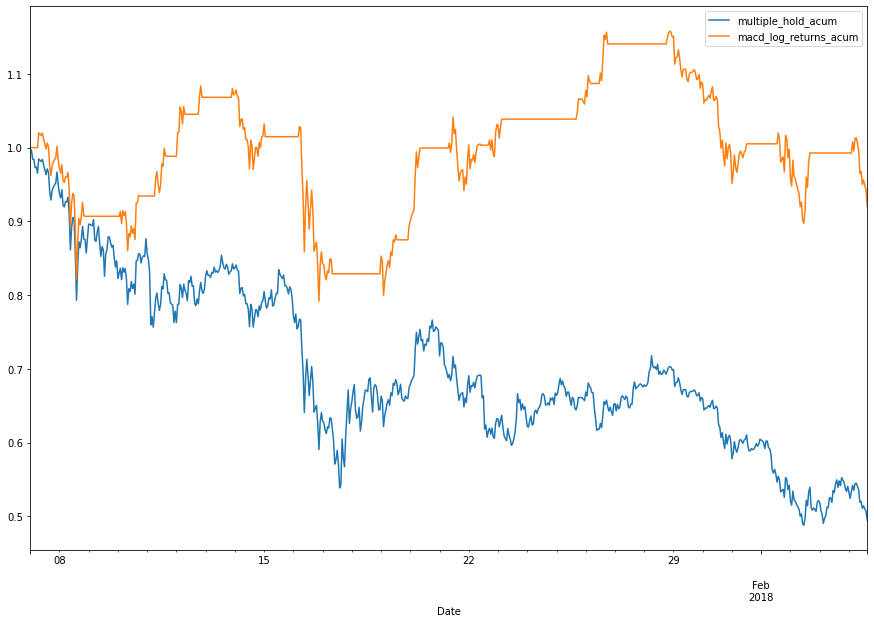

In [10]:
test.data_init.multiple_hold_acum.plot(figsize=(15,10))
test.data_init.macd_log_returns_acum.plot(figsize=(15,10))
plt.legend()

In [7]:
pd.set_option('display.max_rows', None)

In [8]:
test.data_init

,Open,High,Low,Close,Volume,macd_diff,macd_macd,macd_signal,log_returns_hold,multiple_hold_acum,position,peak,trades,macd_log_returns,macd_log_returns_net,macd_log_returns_acum,macd_log_returns_net_acum
Date,,,,,,,,,,,,,,,,,
2018-01-07 00:00:00,17069.79,17099.96,16800.00,17009.09,723.097184,1.518780,135.626185,134.107405,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2018-01-07 01:00:00,16950.04,17017.77,16792.01,16951.02,786.542762,-1.973342,131.926344,133.899685,-0.003420,0.996586,0,0,0,-0.000000,-0.000000,1.000000,1.000000
2018-01-07 02:00:00,16951.02,16967.97,16711.00,16742.94,811.636768,-22.630093,108.887477,131.517570,-0.012351,0.984352,0,0,0,-0.000000,-0.000000,1.000000,1.000000
2018-01-07 03:00:00,16742.94,16800.00,16605.01,16740.68,833.027889,-37.788292,89.751563,127.539855,-0.000135,0.984220,0,0,0,-0.000000,-0.000000,1.000000,1.000000
2018-01-07 04:00:00,16727.93,16740.66,16400.00,16546.93,775.910726,-63.589264,57.256985,120.846249,-0.011641,0.972829,0,0,0,-0.000000,-0.000000,1.000000,1.000000
2018-01-07 05:00:00,16547.59,16744.94,16500.00,16564.00,698.237458,-78.856544,33.689016,112.545560,0.001031,0.973832,0,0,0,0.000000,0.000000,1.000000,1.000000
2018-01-07 06:00:00,16564.00,16683.44,16400.00,16417.05,721.569884,-99.170288,2.936294,102.106582,-0.008911,0.965193,1,1,1,-0.000000,-0.000850,1.000000,0.999150
2018-01-07 07:00:00,16418.00,16749.98,16409.71,16746.99,577.845180,-84.522768,8.686681,93.209449,0.019898,0.984591,1,0,0,0.019898,0.019898,1.020097,1.019230
2018-01-07 08:00:00,16747.00,16886.75,16695.66,16719.02,640.796589,-74.948713,10.371397,85.320110,-0.001672,0.982946,1,0,0,-0.001672,-0.001672,1.018394,1.017528


## Results tested against the result coming from the file '2022Sep3th_BTC_MACD_long_only_CHECK_OK_Working' and it is the same result for the given paramaters: <br>

__1) macd_inst = Macd_long_backtester(symbol='BTCUSDT')__<br>

__2) macd_inst.prepare_data(interval='1d', start='2018-10-29-20:00', end='2022-08-29-20:00')__<br>

__3) macd_inst.assign_trends(window_size=60, plot=True)__<br>

__4) macd_inst.execute_backtest(ema_slow=24, ema_fast=12, ema_signal=9) = (3.2042562870505837, 4.8108773219256085, 4.41872336884791)__<br>

__And now results coming from the mentioned file: <br>
'2022Sep3th_BTC_MACD_long_only_CHECK_OK_Working':__ <br>

__multiple_hold = np.exp(btcusdt.log_returns.sum()) <br>
multiple_hold <br>
3.2042562870505837__

__multiple_macd_strategy = np.exp(btcusdt.macd_log_returns.sum()) <br>
multiple_macd_strategy__ <br>
__4.8108773219256085__ <br>

__multiple_macd_strategy_net = np.exp(btcusdt.macd_log_returns_net.sum()) <br>
multiple_macd_strategy_net__ <br>
__4.41872336884791__ <br>




